In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display
import time
import cv2


In [2]:
#!pip install  tensorflow
#!pip install pydot

In [3]:
root_path = r"E:\data_share_ths\dataset\cityscape_pair_dataset\original_combine"
train_img_path = root_path+"\\images\\train"
train_mask_path = root_path+"\\masks\\train"

test_img_path =  root_path+"\\images\\val"
test_mask_path =  root_path+"\\masks\\val"


In [4]:
IMG_WIDTH = 1024
IMG_HEIGHT = 512
BUFFER_SIZE = 200
BATCH_SIZE = 6
OUTPUT_CHANNELS = 3
EPOCHS = 150

In [5]:
import random
index = int(random.random()*100)
print(index)

54


In [6]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self,x_col,y_col,batch_size, shuffle= True):

        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.n = len(self.x_col)

        
    def on_epoch_end(self):
        pass
    

    def __get_input(self,image_path,mask_path):

        # Read an image from a file
        real_image = cv2.imread(image_path)
        real_image = cv2.resize(real_image,(IMG_WIDTH,IMG_HEIGHT),interpolation = cv2.INTER_AREA)
        real_image = cv2.cvtColor(real_image,cv2.COLOR_BGR2RGB)


        mask_image = cv2.imread(mask_path)
        mask_image = cv2.resize(mask_image,(IMG_WIDTH,IMG_HEIGHT),interpolation = cv2.INTER_AREA)
        mask_image = cv2.cvtColor(mask_image,cv2.COLOR_BGR2RGB)

        #convert to tensor
        real_image = tf.cast(real_image, tf.float32)
        mask_image = tf.cast(mask_image, tf.float32)
        
        #normalize
        real_image = (real_image/127.5)-1
        mask_image = (mask_image/127.5)-1
        
        return real_image,mask_image
    
    def __get_data(self,x_batches,y_batches):
        img_batches,mask_batches =  [],[]
        for x_path, y_path in zip(x_batches,y_batches):
            real_image,mask_image = self.__get_input(x_path, y_path )
            img_batches.append(real_image)
            mask_batches.append(mask_image)
        img_batches = np.asarray(img_batches)
        mask_batches = np.asarray(mask_batches)
       
        return img_batches,mask_batches
        
        
    def __getitem__(self,index):
        X_batches = self.x_col[index*self.batch_size : (index+1)*self.batch_size]
        Y_batches = self.y_col[index*self.batch_size : (index+1)*self.batch_size]

        X,Y= self.__get_data(X_batches,Y_batches)
        return X,Y
    
    
    def __len__(self):
        return self.n // self.batch_size

In [7]:
x_train =[train_img_path+"\\"+x for x in os.listdir(train_img_path)]
y_train =[train_mask_path+"\\"+x for x in os.listdir(train_mask_path)]


In [8]:
x_val =[test_img_path+"\\"+x for x in os.listdir(test_img_path)]
y_val =[test_mask_path+"\\"+x for x in os.listdir(test_mask_path)]

In [9]:
traingen = CustomDataGen(x_col = x_train, y_col=y_train,
                         batch_size = BATCH_SIZE , shuffle= True)

In [10]:
valgen = CustomDataGen(x_col = x_val, y_col=y_val,
                         batch_size = BATCH_SIZE , shuffle= False)

In [11]:
img,seg = traingen.__getitem__(1)
test_img,test_seg = img[0],seg[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


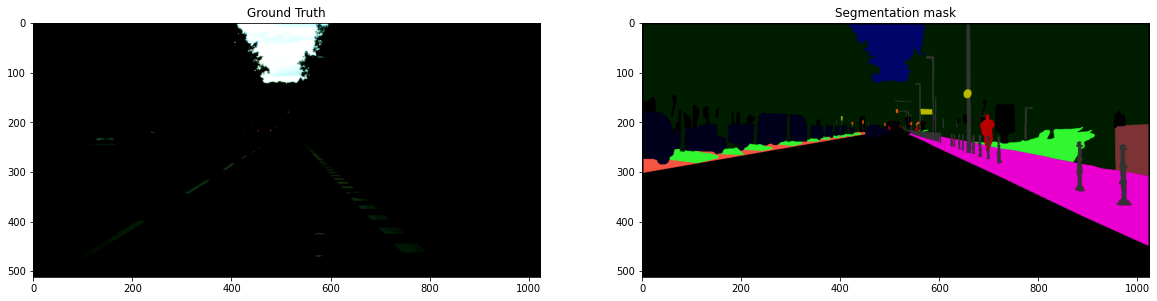

In [12]:



fig = plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title("Ground Truth")
plt.subplot(1,2,2)
plt.imshow(test_seg)
plt.title("Segmentation mask")
plt.show()

In [13]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.26570618>

In [14]:
"""
@tf.function()
def random_jitter(input_img,real_img):
    
    #resize image
    input_image,real_image = resize_img(input_img,real_img,IMG_HEIGHT,IMG_WIDTH)
    
    #random cropping
    input_image,real_image = random_crop(input_image,real_image)
    
    if tf.random.uniform(()) > 0.5:
        
        #random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

"""

'\n@tf.function()\ndef random_jitter(input_img,real_img):\n    \n    #resize image\n    input_image,real_image = resize_img(input_img,real_img,IMG_HEIGHT,IMG_WIDTH)\n    \n    #random cropping\n    input_image,real_image = random_crop(input_image,real_image)\n    \n    if tf.random.uniform(()) > 0.5:\n        \n        #random mirroring\n        input_image = tf.image.flip_left_right(input_image)\n        real_image = tf.image.flip_left_right(real_image)\n        \n    return input_image, real_image\n\n'

In [15]:
#tf.constant("Thanks 😊").shape

In [13]:
tf.constant("Thanks 😊").shape
my_str = tf.constant('Hello World')
my_str_npy = my_str.numpy()

print(my_str_npy)
print(type(my_str_npy))
print(my_str_npy.decode("utf-8") )
my_str


b'Hello World'
<class 'bytes'>
Hello World


<tf.Tensor: shape=(), dtype=string, numpy=b'Hello World'>

In [14]:
def downsample(filters,size,apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters,size,strides = 2, padding='same',
                                     kernel_initializer = initializer,use_bias =False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    
    return result

In [15]:
test_exp_img = tf.expand_dims(test_img,0)
print(test_img.shape)
print(test_exp_img.shape)

(512, 1024, 3)
(1, 512, 1024, 3)


In [16]:
down_model = downsample(3,4)
down_result = down_model(test_exp_img)
print(down_result.shape)

(1, 256, 512, 3)


In [17]:
def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding = 'same',
                                              kernel_initializer = initializer, use_bias = False)
              )
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

In [21]:
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 512, 1024, 3)


In [18]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3]) # (bs, 256,256, 3)
    
    down_stack = [
        downsample( 64, 4, apply_batchnorm = False), # (bs, 128,128, 64)
        downsample(128,4),  # (bs, 64, 64, 128)
        downsample(256,4),  # (bs, 32, 32, 256)
        downsample(512,4),  # (bs, 16, 16, 512)
        downsample(512,4),  # (bs, 8, 8, 512)
        downsample(512,4),  # (bs, 4, 4, 512)
        downsample(512,4),  # (bs, 2, 2, 512)
        downsample(512,4),  # (bs, 1, 1, 512)
        
    ]
    
    
    up_stack = [
        upsample(512,4, apply_dropout = True), # (bs, 2,2, 1024)
        upsample(512,4, apply_dropout = True), # (bs, 4,4, 1024)
        upsample(512,4, apply_dropout = True), # (bs, 8,8, 1024)
        upsample(512,4), # (bs, 16,16, 1024)
        upsample(256,4), # (bs, 32, 32, 512)
        upsample(128,4), # (bs,64, 64, 256)
        upsample(64,4),  # (bs, 128, 128, 128)
    ]
    
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides = 2,
                                          padding = 'same',
                                          kernel_initializer = initializer,
                                          activation = 'tanh') #(bs, 256,256, 3)
    
    x = inputs
    
    
    #Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    #Upsampling and establishing the skip connections
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs,outputs= x)

In [23]:
#!pip install pydot
#!pip install graphviz

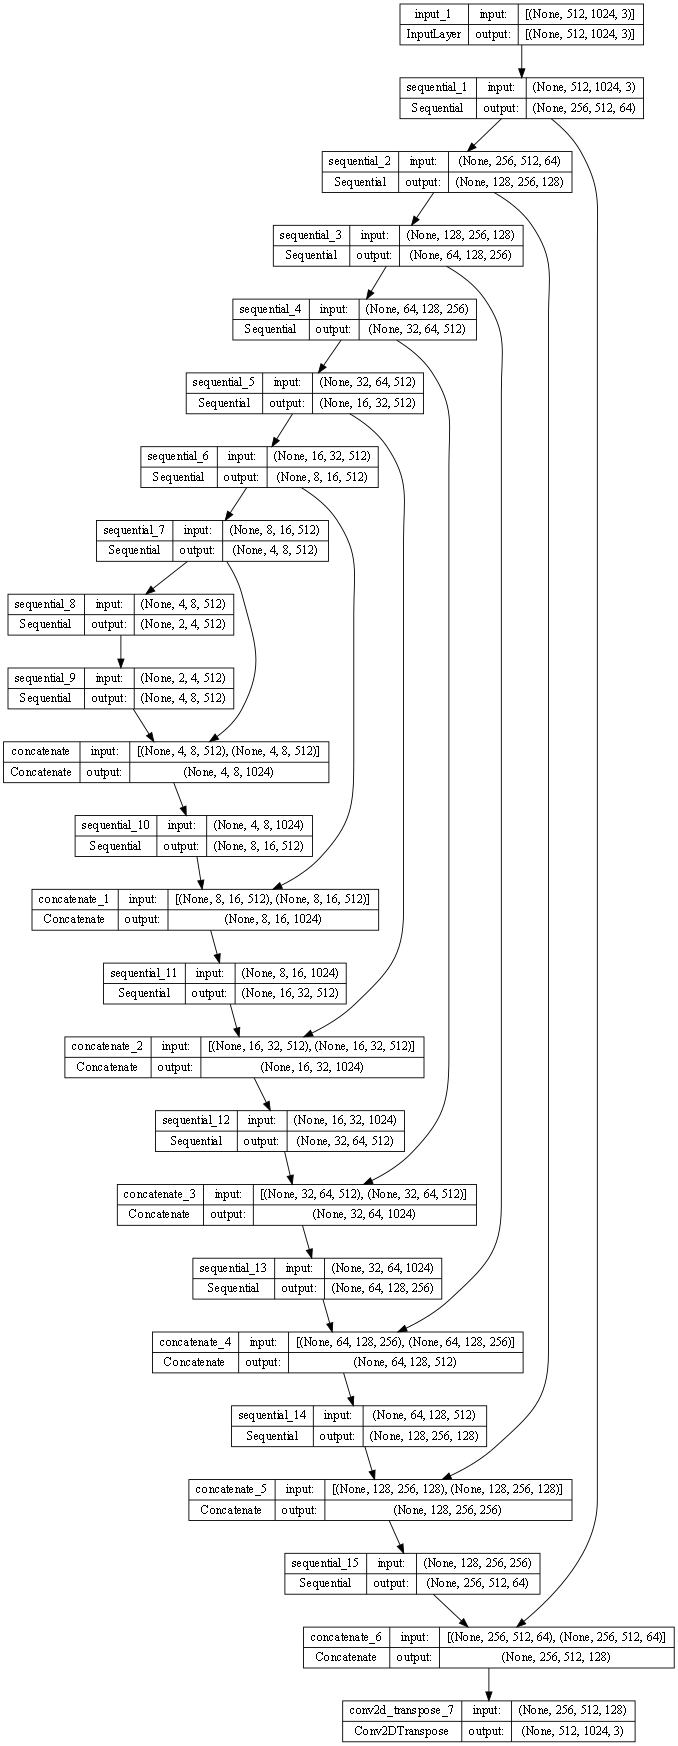

In [19]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


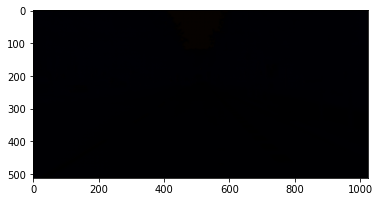

In [27]:
gen_output = generator(test_img[tf.newaxis,...], training = False)
plt.imshow(gen_output[0,...])

In [29]:
print(gen_output[0].shape)

(512, 1024, 3)


In [26]:
loss_object =  tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [27]:
#Generator loss
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gen_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    #mae loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gen_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gen_loss,l1_loss

In [24]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'input_image')
    tar = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'target_image')
    
    x = tf.keras.layers.concatenate([inp,tar]) # (bs, 256,256, channels*2)
    
    down1 = downsample(64,4, False)(x)  # (bs, 128,128,64)
    down2 = downsample(128,4)(down1)    # (bs, 64,64, 128)
    down3 = downsample(256,4)(down2)    # (bs, 32,32,256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34,34, 256)
    
    conv = tf.keras.layers.Conv2D(512, 4, strides = 1,
                                 kernel_initializer = initializer,
                                 use_bias = False)(zero_pad1) #(bs,31,31,512)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) #(bs, 33,33,512)
    
    
    last = tf.keras.layers.Conv2D(1,4, strides=1,
                                 kernel_initializer = initializer)(zero_pad2)# (bs, 30, 30, 1)
    
    
    return tf.keras.Model(inputs = [inp,tar],outputs= last)

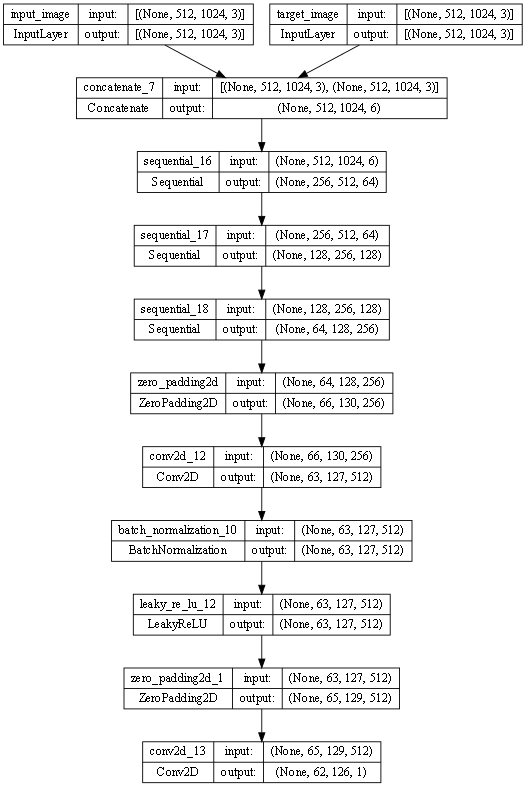

In [25]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [40]:
len([test_img[tf.newaxis,...]])
print(test_img[tf.newaxis,...].shape)
print(gen_output.shape)
test_data = [test_img[tf.newaxis,...], gen_output]

(1, 512, 1024, 3)
(1, 512, 1024, 3)


In [45]:
test_img[tf.newaxis,...].shape

(1, 512, 1024, 3)

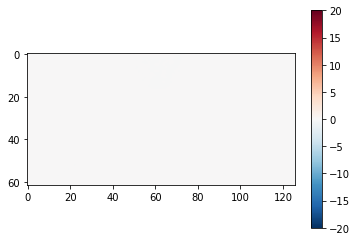

In [42]:
disc_out = discriminator([test_img[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [21]:
def discriminator_loss(disc_real_output,disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    
    return total_disc_loss

In [22]:
generator_optimizer =  tf.keras.optimizers.Adam(2e-4,beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)


In [23]:
checkpoint_dir = r'E:\gans\pix2pix\4-7-2022'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

NameError: name 'discriminator' is not defined

In [34]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

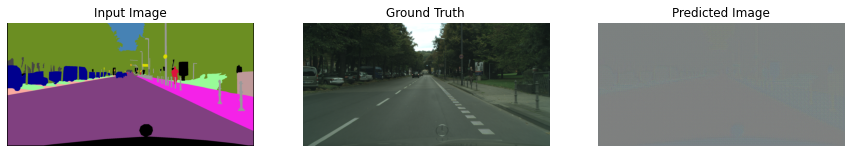

In [35]:

generate_images(generator, seg, img)

In [36]:


import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [37]:
@tf.function
def train_step(input_image,target,epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image,training = True)
        
        disc_real_output = discriminator([input_image,target],training = True)
        disc_generated_output = discriminator([input_image,gen_output], training=True)
        
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,gen_output,target)
        
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)
        
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)
        
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)
        
        
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                   discriminator.trainable_variables))
        
        
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [38]:
print("trainIndex : ",traingen.__len__())
print("testIndex :",valgen.__len__())


trainIndex :  495
testIndex : 83


In [39]:
def fit(train_generator,val_generator,epochs):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait = True)
        
        
        test_img,test_seg = val_generator.__getitem__(1)
      
       
        generate_images(generator,test_input=test_seg,tar=test_img)
        
        print("Epoch :",epoch)
        for i in range(1,train_generator.__len__(),1):
            print(".",end='')
            if (i+1)%100 ==0:
                print()
            img,seg = train_generator.__getitem__(i)
            train_step(seg,img,epoch)
        print()
        
        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix) 

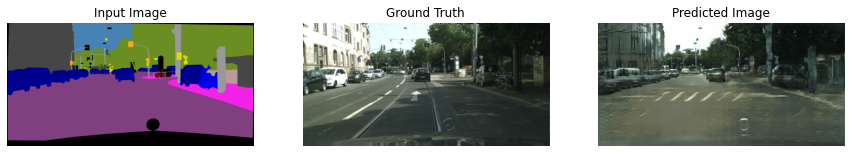

Epoch : 32
...................................................................................................
....................................................................................................
....................................................................................................
..........................................................

In [ ]:
fit(traingen,valgen, EPOCHS)

In [ ]:
checkpoint_dir = r"E:\gans\pix2pix\17-6-2022\training_checkpoints"
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for inp, tar in test_dataset.take(5):

    generate_images(generator, inp, tar)